## overview
- predict performance at next step given next domain to practice on, only train one domain at a time

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import copy
import wandb
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
import random
from scipy.stats import sem

Initialize run

In [2]:
## only looking at sessions where the target_domain is the next domain
target_domain = 1

In [3]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Ensure deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Data

In [4]:
# read in filtered sessions data
df = pd.read_csv("data/filtered_ds.csv")

In [5]:
# sort df by start time min
df["start_time_min"] = df["start_time_min"].astype('datetime64[ns]')
df = df.sort_values(by=["patient_id", "start_time_min"])

Create training data

In [6]:
# given a row of sessions, take domain_ids and domain_scores, which are in string format separated by ",", and replace with a list of the values
def process_row(row):
    values_a = [int(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

In [7]:
# take in a dataframe of a patient's session, extract information useful for training
def create_training_data(data: pd.DataFrame):
    # Initialize variables
    session_row = [] # contents of a row (patient id, encoding, cur score, prev score, repeat)
    overall = [] # aggregate of everything (n sessions x 44)

    cur_score = np.zeros((14)) # score for each session
    prev_score = None

    seen = {} # dictionary for seen
    patient_id = data["patient_id"].iloc[0] # save patient_id

    # Sort data by session start time
    data = data.sort_values(by=["start_time_min"])

    # Process each row
    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)  # returns a list of domains : int and of domain_scores : float

        # Track repeat status and update scores
        repeat = False
        for j, domain in enumerate(domains):
            if domain not in seen:
                seen[domain] = True
            else:
                repeat = True

            cur_score[domain - 1] = domain_scores[j] # update score in the loop

        # Encode domains for this session
        domain_encoding = np.zeros(14)
        for domain in domains:
            domain_encoding[domain - 1] = 1

        # if the session does not contain the target domain or is the first (no prev score), continue in the loop without doing anything, do this before appending
        if target_domain not in domains or prev_score is None or len(domains) != 1: # only sessions that only do one domain
            session_row = []
            prev_score = cur_score.copy()
            continue
        assert target_domain in domains, "continue not working"

        # append everything in the row list
        session_row.append(patient_id)
        session_row.extend(domain_encoding.copy().tolist())
        session_row.extend(prev_score.copy().tolist())
        session_row.extend(cur_score.copy().tolist())
        session_row.append(repeat)
        assert len(session_row) == 44, "session row length weird"

        # append row to overall, reset
        overall.append(session_row)
        session_row = []
        prev_score = cur_score.copy()

        # only one sample
        break

    # Convert to numpy arrays
    if overall:
        overall = np.array(overall)
        assert len(overall.shape) == 2, "dimensions of overall wrong"
    else:
        # Handle case where scores is empty
        return pd.DataFrame(columns=["patient_id"] + ["domain %d encoding" % i for i in range(1, 15)] +
                                   ["domain %d score" % i for i in range(1, 15)] +
                                   ["domain %d target" % i for i in range(1, 15)] +
                                   ["repeat"])
    
        # Create column names
    column_names = (
        ["patient_id"]
        + [f"domain {i} encoding" for i in range(1, 15)]
        + [f"domain {i} score" for i in range(1, 15)]
        + [f"domain {i} target" for i in range(1, 15)]
        + ["repeat"]
    )

    # Create dataframe
    scores_df = pd.DataFrame(overall, columns=column_names)
    scores_df.reset_index(drop=True, inplace=True)
    return scores_df

In [8]:
# apply create_training_data to each individual patients
data = df.groupby("patient_id")[df.columns].apply(create_training_data).reset_index(drop=True)

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_90070/1164513361.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = df.groupby("patient_id")[df.columns].apply(create_training_data).reset_index(drop=True)


In [9]:
## pick a random patient for case study
pid = random.choice(pd.unique(data["patient_id"]))
## save the patient's data
case_study_data = copy.deepcopy(data[data['patient_id'] == pid])
## remove the patient's data from the dataset
model_data = data.drop(data[data['patient_id'] == pid].index)

## reset index for the case study
case_study_data = case_study_data.reset_index(drop=True)

In [10]:
# drop patient_id column
model_data = model_data.drop(["patient_id"], axis=1)

In [11]:
# filter rows based on number of zeros allowed
def filter_nonzero_rows(df, max_zeros, column_names=["domain %d score" %i for i in range(1, 15)]):
    # only use the score columns when counting 0s
    scores = df[column_names]
    # Count number of zeros in each row
    zeros_count = (scores == 0).sum(axis=1)
    
    # Filter rows with at most max_zeros number of zeros
    non_zero_rows = df[zeros_count <= max_zeros]
    return non_zero_rows

In [12]:
model_data.shape

(2595, 43)

In [13]:
# train_data, test_data = train_test_split(model_data, test_size=0.25)

## one sample for train, only to see if it learns that one example
train_data = model_data.iloc[0].copy()
test_data = model_data.iloc[0].copy()

In [14]:
def generate_random_array(rows, cols, N):
    if N > cols:
        raise ValueError("N cannot be greater than the number of columns.")
    
    # Create an array of ones with the desired shape
    array = np.ones((rows, cols), dtype=int)
    
    # Randomly assign N zeros to each row
    for i in range(rows):
        indices = np.random.choice(cols, N, replace=False)
        array[i, indices] = 0
    
    return array, array.shape[0] * N

In [15]:
def generate_mask(data, N=10):
    rows, cols = data.shape
    assert(cols == 14)
    mask, n_zeros = generate_random_array(rows, cols, N)
    data = copy.deepcopy(data)
    return data * mask, n_zeros, mask

In [16]:
def generate_differently_masked_data(original_matrix, dupe_n=14):
    score_columns = ["domain %d score" %i for i in range(1, 15)]
    encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
    target_columns = ["domain %d target" %i for i in range(1, 15)]
    final_matrix_lst = [original_matrix.copy()] * dupe_n
    for i in range(14):
        final_matrix_lst[i][score_columns], _, _ = generate_mask(original_matrix[score_columns], N = i)
    final_matrix = pd.concat(final_matrix_lst)
    return copy.deepcopy(final_matrix[encoding_columns + score_columns]), copy.deepcopy(final_matrix[target_columns])

In [17]:
score_columns = ["domain %d score" %i for i in range(1, 15)]
encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
target_columns = ["domain %d target" %i for i in range(1, 15)]
repeat_columns = ["repeat"]

In [18]:
# train_data, target = generate_differently_masked_data(train_data, dupe_n=14)
target = train_data[target_columns].copy().to_numpy() * train_data[encoding_columns].copy().to_numpy()
train_data = train_data[encoding_columns + score_columns].copy()

In [19]:
target , train_data

(array([0.571, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   ]),
 domain 1 encoding     1.000
 domain 2 encoding     0.000
 domain 3 encoding     0.000
 domain 4 encoding     0.000
 domain 5 encoding     0.000
 domain 6 encoding     0.000
 domain 7 encoding     0.000
 domain 8 encoding     0.000
 domain 9 encoding     0.000
 domain 10 encoding    0.000
 domain 11 encoding    0.000
 domain 12 encoding    0.000
 domain 13 encoding    0.000
 domain 14 encoding    0.000
 domain 1 score        0.585
 domain 2 score        0.000
 domain 3 score        0.000
 domain 4 score        0.643
 domain 5 score        0.450
 domain 6 score        0.000
 domain 7 score        0.000
 domain 8 score        0.000
 domain 9 score        0.950
 domain 10 score       0.807
 domain 11 score       0.000
 domain 12 score       0.507
 domain 13 score       0.703
 domain 14 score       0.000
 Name: 0, dtype: float64)

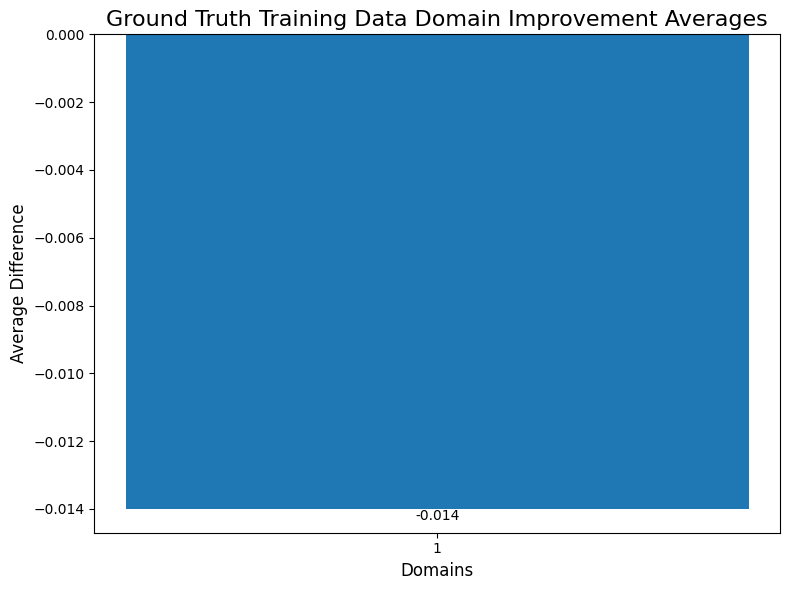

In [20]:
## ground truth
diff = target - train_data[score_columns].to_numpy() * train_data[encoding_columns].to_numpy()


# Calculate column-wise averages
column_averages = np.sum(diff, axis=0) / np.sum(train_data[encoding_columns].to_numpy(), axis=0)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))  # Create the figure and axes
# bars = ax.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])
bars = ax.bar(range(1), column_averages, tick_label=[str(target_domain)])


# Add values to the bars
ax.bar_label(bars, label_type='edge')


# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Ground Truth Training Data Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
train_data = train_data.to_numpy().reshape((1, -1))
target = target.reshape((1, -1))

In [22]:
def create_missing_indicator(data):
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            if p == 0:
                # print("shouldn't be here")
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    return copy.deepcopy(temp)

In [23]:
train_data_scores = create_missing_indicator(train_data[:, -14:])
train_data = np.hstack((train_data[:, :14], train_data_scores))

Model

In [24]:
## input : 14 domain encodings + 14 domains (28 total features with missing indicator)
## output: 28 score (prediction for the scores after next domain)
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 3, 1)  ## single layer test
        )

    def forward(self, x):
        return torch.clamp(self.model(x), min=0, max=1)

In [25]:
class customDataset(Dataset):
    def __init__(self, data, target):
        super().__init__()
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index, :], self.target[index, :]

Training

In [26]:
def train_model(x_train, x_val,y_train, y_val, epochs, model, optimizer, loss_function, history):
    losses = []
    val_losses = []
    w = 14 ## hardcoded

    # data_set = customDataset(x_train, y_train)
    # data_loader = DataLoader(data_set, batch_size=1, shuffle=True)

    for epoch in range(epochs):
        epoch_loss = []
        val_epoch_loss = []
        ## training
        model.train()
        # for batch_x, batch_y in data_loader:
        # Output of Autoencoder
        reconstructed = model(x_train)
        
        # Calculating the loss function
        loss = loss_function(reconstructed, y_train)
        print("epoch %d: " %epoch, reconstructed)

        optimizer.zero_grad()
        loss.backward()

        # store history of weights, bias, gradients in the dictionary history
        history["weight"].append(model.model[0].weight.detach().numpy())
        history["bias"].append(model.model[0].bias.detach().numpy())
        history["gradient"].append(model.model[0].weight.grad.numpy()) ## tracking the column for the first score

        optimizer.step()
        
        # Storing the losses in a list for plotting
        epoch_loss.append(loss.item())

        losses.append(statistics.mean(epoch_loss))

        ## validation
        model.eval()
        with torch.no_grad():
            val_rs = x_val.reshape(-1, w * 3)
            val_t = torch.from_numpy(val_rs)
            val_t = val_t.clone().detach().type(torch.float32)
            answer = model(val_t)
            val_loss = loss_function(answer, torch.from_numpy(y_val.reshape(-1, w)).type(torch.float32))
        val_losses.append(val_loss)
    return losses, val_losses, history, model

In [27]:
num_runs = 1

In [28]:
model = NN()

In [29]:
losses_2d = []
val_losses_2d = []
model_history = {"weight": [], "bias": [], "gradient": []}
for i in range(num_runs):
    model = NN()
    epochs = 25
    lr = 0.001

    # Validation using MSE Loss function
    loss_function = torch.nn.MSELoss()
    
    # Using an Adam Optimizer
    optimizer = torch.optim.Adam(model.parameters(),
                                lr = lr)
    
    # x_train, x_val, y_train, y_val = train_test_split(train_data, target, test_size=0.50)
    x_train = torch.from_numpy(train_data.copy()).float()
    x_val = train_data.copy()
    y_train = torch.from_numpy(target.copy()).float()
    y_val = target.copy()

    model.eval()
    with torch.no_grad():
        predictions = model(x_train)
        zero_loss = loss_function(predictions, y_train)

        predictions = model(torch.from_numpy(x_val).float())
        zero_loss_val = loss_function(predictions, torch.from_numpy(y_val).float())
    
    losses, val_losses, model_history, model = train_model(x_train, x_val, y_train, y_val, epochs, model, optimizer, loss_function, model_history)
    losses = [zero_loss.item()] + losses
    val_losses = [zero_loss_val.item()] + val_losses
    
    losses_2d.append(losses)
    val_losses_2d.append(val_losses)

epoch 0:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 1:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 2:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 3:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 4:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 5:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 6:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 7:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 8:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 9:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 10:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 11:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 12:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 13:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 14:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 15:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 16:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 17:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 18:  tensor([[0.]], grad_fn=<ClampBackward1>)
epoch 19:  tensor([[0.

/opt/homebrew/anaconda3/envs/ct/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [30]:
def plot_mean_and_std(data, color_choice="blue", setting=""):
    """
    Plots the mean and standard deviation across multiple lists of data.
    
    Parameters:
    - data (list of lists): A list where each element is a list of numbers.
    
    The function will compute the mean and standard deviation at each point
    across the lists and plot these as a line for the mean and shading for the
    standard deviation.
    """
    # Convert data to a NumPy array for easier manipulation
    data_array = np.array(data)
    
    # Calculate mean and standard deviation
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    # print(means, stds)
    
    # Create the x-axis values
    x_values = np.arange(len(means))
    
    # Plotting
    plt.plot(x_values, means, label='%s Mean' % setting, color=color_choice)  # Mean line
    plt.fill_between(x_values, means - stds, means + stds, color=color_choice, alpha=0.2, label='%s Standard Deviation' % setting)
    
    plt.title('Mean and Standard Deviation Plot of %s' % setting)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)

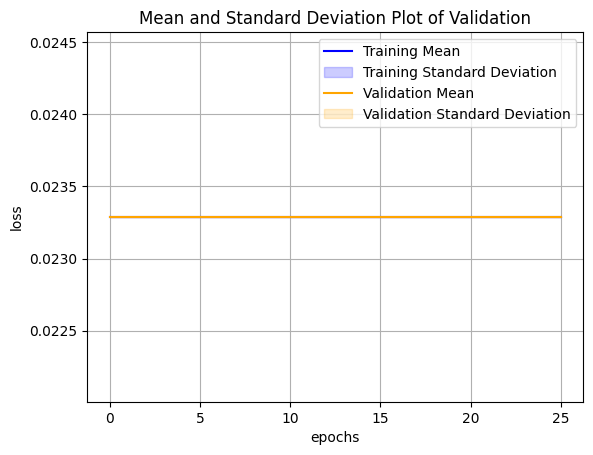

In [31]:
# Defining the Plot Style

# Plotting
if num_runs != 0:
    with torch.no_grad():
        plot_mean_and_std(losses_2d, "blue", "Training")
        plot_mean_and_std(val_losses_2d, "orange", "Validation")

In [32]:
with torch.no_grad():
    predictions = model(x_train)
    loss = loss_function(predictions, y_train)

loss, predictions, y_train

(tensor(0.0233),
 tensor([[0.]]),
 tensor([[0.5710, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]))

In [33]:
l2norm_gradient = [np.linalg.norm(arr) for arr in model_history["gradient"]]

In [34]:
model_history["weight"]

[array([[ 0.13776545,  0.08919653, -0.06745719,  0.08907387,  0.02760892,
          0.07836065, -0.09404868, -0.1527462 , -0.05961673, -0.1183542 ,
          0.1266119 ,  0.0444442 ,  0.06391454,  0.04880016, -0.00268426,
          0.12075908, -0.10963463,  0.00971551, -0.10531824,  0.04757975,
         -0.05313934,  0.04728106, -0.03214779,  0.12797794, -0.09145589,
         -0.09202621, -0.09203177,  0.13878705,  0.05142177,  0.14847851,
         -0.1273429 , -0.15304981, -0.12072136, -0.10379818,  0.06249905,
          0.05525231,  0.12821442, -0.07968616, -0.10519042,  0.08186999,
         -0.06237011,  0.09365039]], dtype=float32),
 array([[ 0.13776545,  0.08919653, -0.06745719,  0.08907387,  0.02760892,
          0.07836065, -0.09404868, -0.1527462 , -0.05961673, -0.1183542 ,
          0.1266119 ,  0.0444442 ,  0.06391454,  0.04880016, -0.00268426,
          0.12075908, -0.10963463,  0.00971551, -0.10531824,  0.04757975,
         -0.05313934,  0.04728106, -0.03214779,  0.12797794

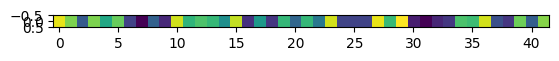

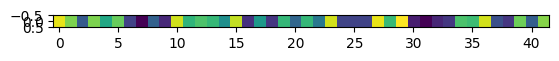

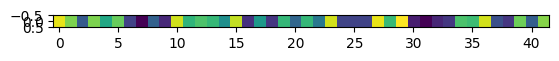

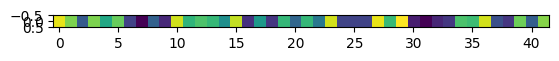

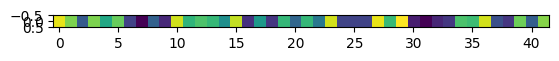

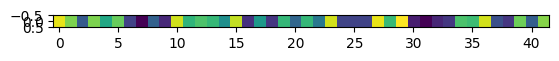

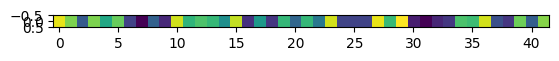

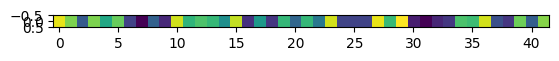

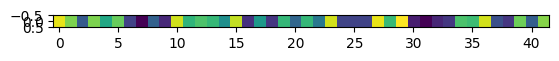

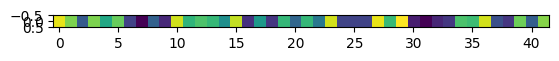

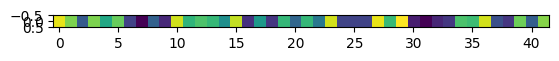

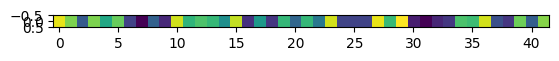

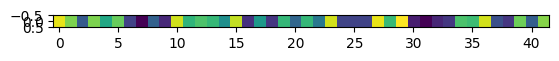

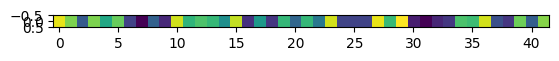

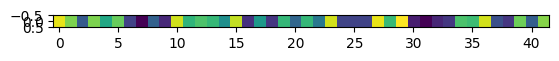

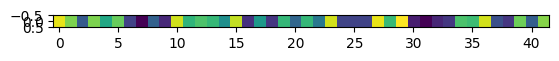

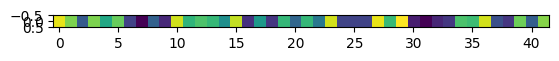

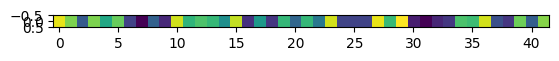

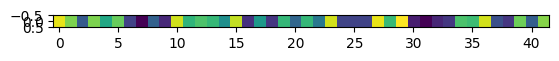

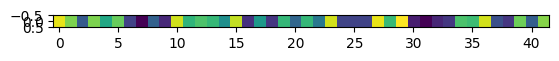

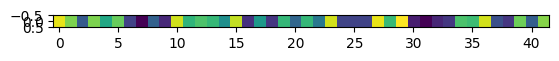

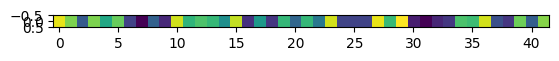

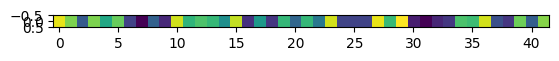

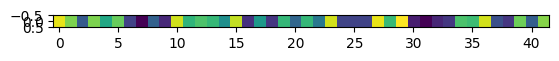

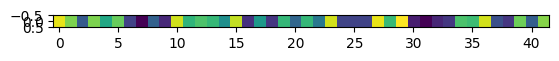

In [35]:
for i in range(len(model_history["weight"])):
    plt.figure()
    plt.imshow(model_history["weight"][i])
    plt.show()

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_90070/759946412.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


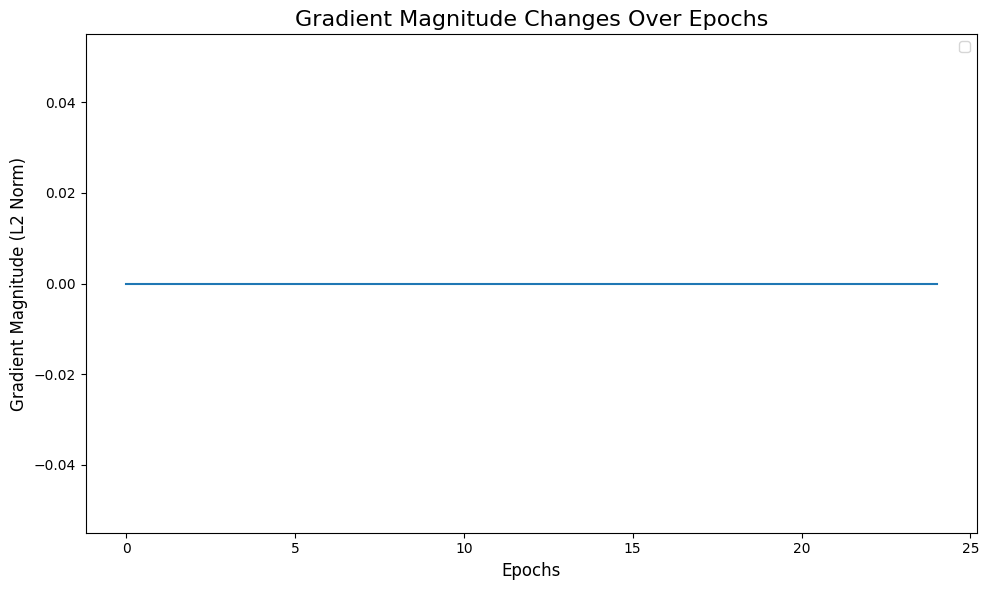

In [36]:
# Plot gradient magnitudes
plt.figure(figsize=(10, 6))

plt.plot(range(len(l2norm_gradient)), l2norm_gradient)

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Gradient Magnitude (L2 Norm)", fontsize=12)
plt.title("Gradient Magnitude Changes Over Epochs", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


### Quantitative (overall baseline vs prediction view)
- compare our prediction to baseline in test set in a quantitative manner (rather than looking at an individual heatmap)

In [ ]:
if num_runs == 0: ## no training, take from previously saved model
    print("loading old model")
    model = NN()
    model = torch.load("model/next_step_3.pt")

In [ ]:
## take in dataframe, return known domain average for prediction, modified from baseline quant 11/04/2024
def known_domain_average(data : pd.DataFrame):
    """
    Imputes missing values (NaN) in a DataFrame with the average of the non-missing values in the same row.

    Parameters:
    - data (pd.DataFrame): The DataFrame to impute.

    Returns:
    - pd.DataFrame: The DataFrame with missing values imputed.
    """
    assert(data.shape[1] == 14 * 2) ## make sure that the dataframe is the right shape with encoding, current, and target

    # separate encoding, scores, and target (which we dont need so ignored in here)
    encoding = data.iloc[:, :14].copy()
    data_ = data.iloc[:, 14:28].copy()

    # Replace '0' with NaN to handle them as missing values
    data_ = data.replace(0, np.nan)
    # initialize the list we are going to use to store all known domain average
    known_domain_average_lst = []

    # Iterate over each row
    for index, row in data_.iterrows():
        # Calculate the mean of the non-NaN values in the row
        mean_value = row.mean()
        # if there are no known domains, we say known domain average is 0
        if np.isnan(mean_value):
            mean_value = 0
        # append the average onto the list
        known_domain_average_lst.append(mean_value)
        # in the encoding df, replace na with 
        encoding.loc[index] = encoding.loc[index].replace(1, mean_value)
    
    return encoding

In [ ]:
def get_accuracy(y_pred, y_true, n, fn : str):
    diff = y_pred - y_true
    if fn == "mse":
        return np.sum(np.power(diff, 2)) / n
    elif fn == "mae":
        return np.sum(np.abs(diff)) / n

In [ ]:
# get predictions from the model
def predict(data, model):
    model.eval()
    data_t = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        return model(data_t).clone().detach().numpy()

In [ ]:
'''accuracy_list_prediction_sq = []
accuracy_list_knownimputation_sq = []
accuracy_list_prediction_abs = []
accuracy_list_knownimputation_abs = []

for masked_number in range(14):
    # Count the number of rows with exactly 'masked_number' missing values (indicated by 0)
    masked_rows = (test_data[score_columns] == 0).sum(axis=1) == masked_number
    masked_test_data = test_data[masked_rows]
    
    if masked_test_data.shape[0] == 0:
        # If no rows have the required number of missing values, append NaN and continue
        accuracy_list_prediction_abs.append(np.nan)
        accuracy_list_knownimputation_abs.append(np.nan)
        accuracy_list_prediction_sq.append(np.nan)
        accuracy_list_knownimputation_sq.append(np.nan)
        continue

    # known domain average prediction for the next domains
    baseline_prediction = known_domain_average(masked_test_data[encoding_columns + score_columns]).to_numpy()

    # predict
    masked_test_data_ = copy.deepcopy(masked_test_data[encoding_columns + score_columns])
    masked_test_data_ = masked_test_data_.to_numpy()
    test_data_scores = create_missing_indicator(masked_test_data_[:, -14:])
    masked_test_data_ = np.hstack((masked_test_data_[:, :14], test_data_scores))
    model_prediction = predict(masked_test_data_, model)
    model_prediction = np.multiply(model_prediction, masked_test_data[encoding_columns].to_numpy()) # element wise multiply the two so we have the same form as baseline prediction
    # we only have the values we are predicting in the matrix, everything else is 0

    # get accuracy (abs)
    original = masked_test_data[target_columns].copy().to_numpy() # ground truth
    original = np.multiply(original, masked_test_data[encoding_columns].copy().to_numpy()) # element wise multiply the two so we only have the scores we care about predicting
    assert original.shape == model_prediction.shape and original.shape == baseline_prediction.shape
    n_predicting = np.sum(masked_test_data[encoding_columns].copy().to_numpy())

    accuracy_list_prediction_abs.append(get_accuracy(model_prediction, original, n_predicting, "mae"))
    accuracy_list_knownimputation_abs.append(get_accuracy(baseline_prediction, original, n_predicting, "mae"))

    # get accuracy (sq)
    accuracy_list_prediction_sq.append(get_accuracy(model_prediction, original, n_predicting, "mse"))
    accuracy_list_knownimputation_sq.append(get_accuracy(baseline_prediction, original, n_predicting, "mse"))'''

In [ ]:
'''fig = plt.figure(figsize=(12, 12))
# plt.errorbar(range(0, 14), accuracy_list_prediction_sq, yerr=error_prediction_sq, label="model", linewidth=3)
# plt.errorbar(range(0, 14), accuracy_list_imputation_sq, yerr=error_imputation_sq, label="baseline")

x_values = range(0, 14)

plt.plot(x_values, accuracy_list_prediction_sq, label="model", marker="o")
plt.plot(x_values, accuracy_list_knownimputation_sq, label="baseline", marker="o")

for x, y1, y2 in zip(x_values, accuracy_list_prediction_sq, accuracy_list_knownimputation_sq):
    offset = 10

    label = "{:.4f}".format(y1)
    plt.annotate(label, # this is the text
                (x,y1), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
    
    label = "{:.4f}".format(y2)
    plt.annotate(label, # this is the text
                (x,y2), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,-10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center



plt.xlabel("number of masked domains")
plt.ylabel("mean squared error")
plt.title("Mean squared error vs number of masked domains")
plt.legend()'''

In [ ]:
'''fig = plt.figure(figsize=(12, 12))
# plt.errorbar(range(0, 14), accuracy_list_prediction_abs, yerr=error_prediction_abs, label="prediction", linewidth=3)
# plt.errorbar(range(0, 14), accuracy_list_imputation_abs, yerr=error_imputation_abs, label="imputation")
x_values = range(0, 14)

plt.plot(x_values, accuracy_list_prediction_abs, label="model", marker="o")
plt.plot(x_values, accuracy_list_knownimputation_abs, label="baseline", marker="o")

for x, y1, y2 in zip(x_values, accuracy_list_prediction_abs, accuracy_list_knownimputation_abs):

    label = "{:.4f}".format(y1)
    plt.annotate(label, # this is the text
                (x,y1), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
    
    label = "{:.4f}".format(y2)
    plt.annotate(label, # this is the text
                (x,y2), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,-10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
    

plt.xlabel("number of masked domains")
plt.ylabel("mean absolute error")
plt.title("Mean absolute erorr vs number of masked domains")
plt.legend()'''

### Visualization
- visualize individual patient's trajectory (ground truth vs prediction vs imputation?)
- look at overall quantitative picture

In [ ]:
column_names = ["domain %d score" % i for i in range(1, 15)]
column_rename_dict = {}
for i in range(len(column_names)):
    column_rename_dict[column_names[i]] = i + 1

In [ ]:
# takes in a matrix, returns a list mean along rows
def get_score(data):
    return np.mean(data, axis=1)

In [ ]:
# get ground truth scores (overall)
GT_scores = get_score(case_study_data[column_names].to_numpy())

In [ ]:
# get prediction scores
model.eval()
with torch.no_grad():
    test_data_case = case_study_data[encoding_columns + score_columns].to_numpy()
    test_data_scores = create_missing_indicator(test_data_case[:, -14:])
    test_data_case = np.hstack((test_data_case[:, :14], test_data_scores))
    predictions = model(torch.from_numpy(test_data_case).type(torch.float32)).detach().numpy()

In [ ]:
n_missing = np.sum(case_study_data[encoding_columns].to_numpy())
target_ = np.multiply(case_study_data[target_columns].to_numpy(), case_study_data[encoding_columns].to_numpy()) # only the targets we want to predict
prediction_ = np.multiply(predictions, case_study_data[encoding_columns].to_numpy()) # only the scores we want to predict
mse_ = np.divide(np.sum(np.abs(target_ - prediction_)), n_missing)

In [ ]:
# mask for which columns we are trying to predict
mask = case_study_data[encoding_columns].to_numpy()

In [ ]:
prediction_only = pd.DataFrame(mask * predictions, columns=column_names)
target_only = pd.DataFrame(mask * case_study_data[target_columns].to_numpy(), columns=column_names)

In [ ]:
## plot specific domain progression
plt.figure()
plt.plot(range(case_study_data.shape[0]), case_study_data["domain %d target" % target_domain])
plt.show()
plt.figure()
plt.plot(range(case_study_data.shape[0]), predictions[:, target_domain - 1])
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 18))
vmin = 0
vmax = 1

plt.subplot(2, 2, 1)
sns.heatmap(prediction_only, cmap="viridis", cbar=True, vmin=vmin, vmax=vmax)
plt.title("model prediction (next step domains only)")

plt.subplot(2, 2, 2)
sns.heatmap(target_only, cmap="viridis", cbar=True, vmin=vmin, vmax=vmax)
plt.title("ground truth (next step domains only)")

plt.subplot(2, 2, 3)
sns.heatmap(case_study_data[score_columns], cmap="viridis", cbar=True, vmin=vmin, vmax=vmax)
plt.title("full ground truth")

fig.tight_layout()
fig.subplots_adjust(hspace=0.2)

In [ ]:
np.unique(df[df.patient_id == pid]["domain_ids"])

In [ ]:
## ground truth
diff = test_data[target_columns].to_numpy() * test_data[encoding_columns].to_numpy() - test_data[score_columns].to_numpy() * test_data[encoding_columns].to_numpy()


# Calculate column-wise averages
column_averages = np.sum(diff, axis=0) / np.sum(test_data[encoding_columns].to_numpy(), axis=0)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))  # Create the figure and axes
# bars = ax.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])
bars = ax.bar(range(1), column_averages, tick_label=[str(target_domain)])

# Add values to the bars
ax.bar_label(bars, label_type='edge')

# Set the y-axis range from -1 to 1
ax.set_ylim(-1, 1)

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Test Data Ground Truth Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
test_data_input = test_data[encoding_columns + score_columns].copy().to_numpy().reshape((1, -1))
test_data_scores = create_missing_indicator(test_data_input[:, -14:])
test_data_input = np.hstack((test_data_input[:, :14], test_data_scores))

In [ ]:
predictions = model(torch.from_numpy(test_data_input).float())

In [ ]:
predictions

In [ ]:
diff = predictions.detach().numpy() * test_data[encoding_columns].to_numpy() - test_data[score_columns].to_numpy() * test_data[encoding_columns].to_numpy()

In [ ]:
np.sum(test_data[encoding_columns].to_numpy(), axis=0)

In [ ]:
diff

In [ ]:
# Calculate column-wise averages
column_averages = np.sum(diff, axis=0) / np.sum(test_data[encoding_columns].to_numpy(), axis=0)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))  # Create the figure and axes
# bars = ax.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])
bars = ax.bar(range(1), column_averages, tick_label=[str(target_domain)])

# Add values to the bars
ax.bar_label(bars, label_type='edge')

# Set the y-axis range from -1 to 1
ax.set_ylim(-1, 1)

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("All Prediction Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
diff.shape

In [ ]:
repeat_test = test_data[repeat_columns].to_numpy().copy().flatten()
repeat_test.shape

In [ ]:
train_data

In [ ]:
target

In [ ]:
predict(train_data, model)

In [ ]:
sample = torch.from_numpy(train_data).float().clone().detach().requires_grad_(True)
target_sample = torch.from_numpy(target).float().clone().detach()

for i, layer in enumerate(model.model):
    # Forward pass
    sample = layer(sample)

    # Retain gradients for intermediate outputs
    sample.retain_grad()

    # Print output differences layer-by-layer
    print(f"Layer {i} Output: {sample}")

# Compute MSE Loss
loss = F.mse_loss(sample, target_sample)
print("loss: ", loss)

# Backward pass for gradients
loss.backward(retain_graph=True)

# Compare gradients for weights and biases layer-by-layer
for j, layer in enumerate(model.model):
    if isinstance(layer, nn.Linear):  # Only compare Linear layers
        print(f"Layer {j} Weight Gradient: {layer.bias.grad}")

In [ ]:
repeats_diff_gt = test_data[repeat_test == 1][target_columns].to_numpy() * test_data[repeat_test == 1][encoding_columns].to_numpy() - test_data[repeat_test == 1][score_columns].to_numpy() * test_data[repeat_test == 1][encoding_columns].to_numpy()

In [ ]:
non_repeat_diff_gt = test_data[repeat_test == 0][target_columns].to_numpy() * test_data[repeat_test == 0][encoding_columns].to_numpy() - test_data[repeat_test == 0][score_columns].to_numpy() * test_data[repeat_test == 0][encoding_columns].to_numpy()

In [ ]:
repeats_diff = diff[repeat_test == 1]
non_repeats_diff = diff[repeat_test == 0]

In [ ]:
repeats_n = test_data[encoding_columns].to_numpy()[repeat_test == 1]
non_repeats_n = test_data[encoding_columns].to_numpy()[repeat_test == 0]

In [ ]:
# Calculate column-wise averages
column_averages = np.sum(repeats_diff_gt, axis=0) / np.sum(repeats_n, axis=0)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))  # Create the figure and axes
# bars = ax.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])
bars = ax.bar(range(1), column_averages, tick_label=[str(target_domain)])

# Add values to the bars
ax.bar_label(bars, label_type='edge')

# Set the y-axis range from -1 to 1
ax.set_ylim(-1, 1)

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Repeat Ground Truth Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Calculate column-wise averages
column_averages = np.sum(repeats_diff, axis=0) / np.sum(repeats_n, axis=0)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))  # Create the figure and axes
# bars = ax.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])
bars = ax.bar(range(1), column_averages, tick_label=[str(target_domain)])

# Add values to the bars
ax.bar_label(bars, label_type='edge')

# Set the y-axis range from -1 to 1
ax.set_ylim(-1, 1)

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Repeat Prediction Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Calculate column-wise averages
column_averages = np.sum(non_repeat_diff_gt, axis=0) / np.sum(repeats_n, axis=0)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))  # Create the figure and axes
# bars = ax.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])
bars = ax.bar(range(1), column_averages, tick_label=[str(target_domain)])

# Add values to the bars
ax.bar_label(bars, label_type='edge')

# Set the y-axis range from -1 to 1
ax.set_ylim(-1, 1)

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Repeat Ground Truth Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Calculate column-wise averages
column_averages = np.sum(non_repeats_diff, axis=0) / np.sum(non_repeats_n, axis=0)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))  # Create the figure and axes
# bars = ax.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])
bars = ax.bar(range(1), column_averages, tick_label=[str(target_domain)])

# Add values to the bars
ax.bar_label(bars, label_type='edge')

# Set the y-axis range from -1 to 1
ax.set_ylim(-1, 1)

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Non Repeat Prediction Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# store model as 
# torch.save(model, "model/next_step_5.pt")